import packages

In [1]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
# # # # #
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml.stat import Correlation
from pyspark.ml import feature, regression, evaluation, Pipeline
# from pyspark.ml import 

read the file

In [2]:
def get_training_filename(data_file_name):
    full_path_name = data_file_name
    return full_path_name

In [3]:
raw_df = spark.read.csv(get_training_filename('train.csv'), header=True, inferSchema=True)

check the dataset property

In [4]:
raw_df.show(5)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001| P00069042|     F|0-17|        10|            A|                         2|             0|                 3|              null|              null|    8370|
|1000001| P00248942|     F|0-17|        10|            A|                         2|             0|                 1|                 6|                14|   15200|
|1000001| P00087842|     F|0-17|        10|            A|                         2|             0|                12|              null|              null|    1422|
|100

Shape of the dataset

In [5]:
shape=(raw_df.count(),len(raw_df.columns))
print(shape)

(550068, 12)


schema of the dataset

In [6]:
print(raw_df.printSchema())

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)

None


See if there is any missing value

In [7]:
raw_df.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in raw_df.columns]).show()

+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender|Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|      0|         0|     0|  0|         0|            0|                         0|             0|                 0|            173638|            383247|       0|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+



In [8]:
# raw_df.na.fill(0, 'Product_Category_2')
# raw_df.na.fill(0)
# df=raw_df.na.replace('null', '0', 'Product_Category_2')
# raw_df.fillna({'Product_Category_2':0, 'Product_Category_3':0})

# fillna is used to replace null values and you have '' (empty string) in your type column; 
# To replace a general value you can use na.replace method:
# df=df.na.replace('null', '0', 'Product_Category_3')

# None of these works

Only 2 columns contain missing values, they are 'Product_Category_2', 'Product_Category_3' <br/>
Replace the missing values with 0

In [9]:
df=raw_df.na.fill({'Product_Category_2':0, 'Product_Category_3':0})

In [10]:
df.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender|Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|      0|         0|     0|  0|         0|            0|                         0|             0|                 0|                 0|                 0|       0|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+



In [11]:
df.select(sum([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in df.columns]).alias('total NAs')).show()

+---------+
|total NAs|
+---------+
|        0|
+---------+



In [12]:
df.show(3)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001| P00069042|     F|0-17|        10|            A|                         2|             0|                 3|                 0|                 0|    8370|
|1000001| P00248942|     F|0-17|        10|            A|                         2|             0|                 1|                 6|                14|   15200|
|1000001| P00087842|     F|0-17|        10|            A|                         2|             0|                12|                 0|                 0|    1422|
+---

## Exploratory Data Analysis

### Explore the Y variable

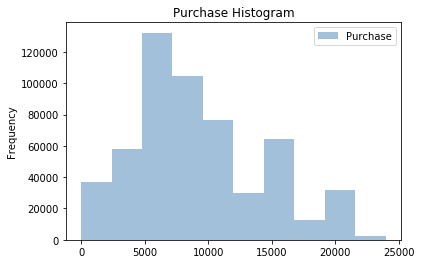

In [13]:
df.select('Purchase').toPandas().plot(kind='hist',title='Purchase Histogram',alpha=0.5,color='steelblue');

In [14]:
df.select('Purchase').describe().show()

+-------+-----------------+
|summary|         Purchase|
+-------+-----------------+
|  count|           550068|
|   mean|9263.968712959126|
| stddev|5023.065393820554|
|    min|               12|
|    max|            23961|
+-------+-----------------+



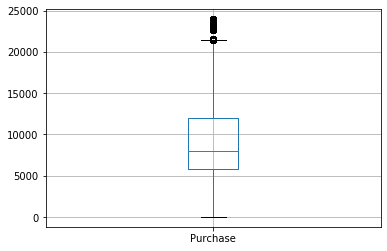

In [15]:
df.select('Purchase').toPandas().boxplot();
# plot(kind='boxplot',title='Purchase Box Plot',alpha=0.5,color='steelblue');

In [16]:
# df.describe().show()

### User ID

In [17]:
df.select(fn.countDistinct('User_ID')).show()

+-----------------------+
|count(DISTINCT User_ID)|
+-----------------------+
|                   5891|
+-----------------------+



There are 5891 unique users in the training dataset.

In [18]:
df.groupBy('User_ID').count().orderBy('count', ascending=False).show(5)

+-------+-----+
|User_ID|count|
+-------+-----+
|1001680| 1026|
|1004277|  979|
|1001941|  898|
|1001181|  862|
|1000889|  823|
+-------+-----+
only showing top 5 rows



Some users bought many products. 

### Product ID

In [19]:
df.select(fn.countDistinct('Product_ID')).show()

+--------------------------+
|count(DISTINCT Product_ID)|
+--------------------------+
|                      3631|
+--------------------------+



There are 3631 unique products in the training dataset.

In [20]:
df.groupBy('Product_ID').count().orderBy('count', ascending=False).show(5)

+----------+-----+
|Product_ID|count|
+----------+-----+
| P00265242| 1880|
| P00025442| 1615|
| P00110742| 1612|
| P00112142| 1562|
| P00057642| 1470|
+----------+-----+
only showing top 5 rows



The most popular product has been bought more than 1800 times

### Gender

In [21]:
df.groupBy('Gender').count().show()

+------+------+
|Gender| count|
+------+------+
|     F|135809|
|     M|414259|
+------+------+



There are 414259 male buyers and 135809 female buyers.

Are females buying higher value purchases than males ?

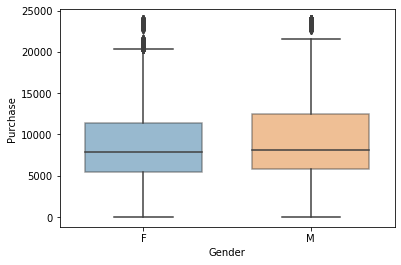

In [22]:
Purchase_by_gender=df.select('Purchase','Gender').toPandas()
sns.boxplot(x=Purchase_by_gender['Gender'],y=Purchase_by_gender['Purchase'],orient="v",width=0.7,boxprops=dict(alpha=.5)); 

It seems males buying higher value purchases than females. But the difference is not significant.

### Age

In [23]:
df.groupBy('age').count().show()

+-----+------+
|  age| count|
+-----+------+
|18-25| 99660|
|26-35|219587|
| 0-17| 15102|
|46-50| 45701|
|51-55| 38501|
|36-45|110013|
|  55+| 21504|
+-----+------+



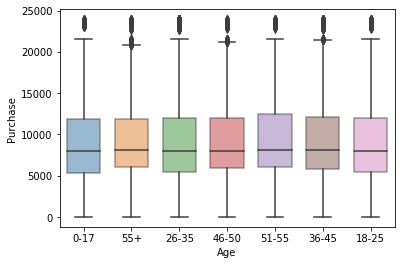

In [24]:
Purchase_by_Age=df.select('Purchase','Age').toPandas()
sns.boxplot(x=Purchase_by_Age['Age'],y=Purchase_by_gender['Purchase'],orient="v",width=0.7,boxprops=dict(alpha=.5)); 

### Occupation

In [25]:
df.select(fn.countDistinct('Occupation')).show()

+--------------------------+
|count(DISTINCT Occupation)|
+--------------------------+
|                        21|
+--------------------------+



Are purchase value clear vary based on occupation value ?

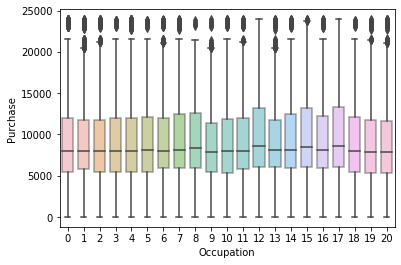

In [26]:
Purchase_by_Occupation=df.select('Purchase','Occupation').toPandas()
sns.boxplot(x=Purchase_by_Occupation['Occupation'],y=Purchase_by_Occupation['Purchase'],orient="v",width=0.7,boxprops=dict(alpha=.5)); 

Occupation value did not affect Purchase value dignificantly since the mean values of purchase at each occupation value are close to each other.

In [27]:
df.select(fn.corr('Occupation', "Purchase")).show()

+--------------------------+
|corr(Occupation, Purchase)|
+--------------------------+
|      0.020832616924612683|
+--------------------------+



### City_Category

In [28]:
df.select(fn.countDistinct('City_Category')).show()

+-----------------------------+
|count(DISTINCT City_Category)|
+-----------------------------+
|                            3|
+-----------------------------+



In [29]:
df.groupBy('City_Category').count().orderBy('count', ascending=False).show()


+-------------+------+
|City_Category| count|
+-------------+------+
|            B|231173|
|            C|171175|
|            A|147720|
+-------------+------+



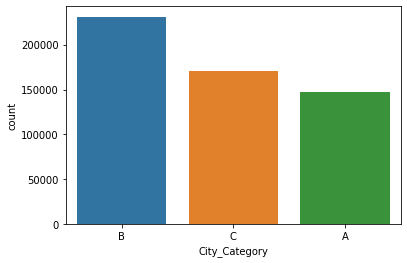

In [30]:
City_Category_Count=df.groupBy('City_Category').count().toPandas()
sns.barplot(x='City_Category', y='count',data=City_Category_Count);

Purchasers who live in city of category B has largest number of Purchasers than A and C.

Are purchase value clear vary based on City Category ?

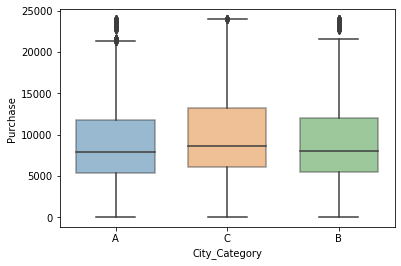

In [31]:
Purchase_by_City_Category=df.select('Purchase','City_Category').toPandas()
sns.boxplot(x=Purchase_by_City_Category['City_Category'],y=Purchase_by_City_Category['Purchase'],orient="v",width=0.7,boxprops=dict(alpha=.5)); 

Purchase value doesn't significantly vary from one city category to another. But we can say that people who live in city of category C purchase a little more than peoples who live in cities of category A or B.

### Stay_In_Current_City_Years

In [32]:
df.select(fn.countDistinct('Stay_In_Current_City_Years')).show()

+------------------------------------------+
|count(DISTINCT Stay_In_Current_City_Years)|
+------------------------------------------+
|                                         5|
+------------------------------------------+



In [33]:
df.groupBy('Stay_In_Current_City_Years').count().orderBy('count', ascending=False).show()

+--------------------------+------+
|Stay_In_Current_City_Years| count|
+--------------------------+------+
|                         1|193821|
|                         2|101838|
|                         3| 95285|
|                        4+| 84726|
|                         0| 74398|
+--------------------------+------+



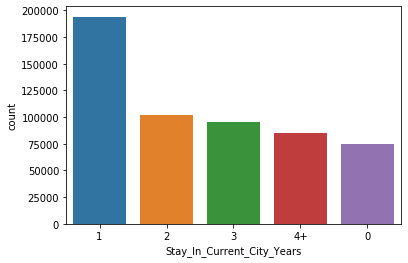

In [34]:
Stay_Count=df.groupBy('Stay_In_Current_City_Years').count().orderBy('count', ascending=False).toPandas()
sns.barplot(x='Stay_In_Current_City_Years', y='count',data=Stay_Count);

Are people who stay more years buy less than people who stay less ?

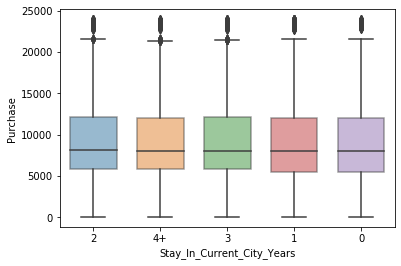

In [35]:
Purchase_by_Stay=df.select('Purchase','Stay_In_Current_City_Years').toPandas()
sns.boxplot(x='Stay_In_Current_City_Years',y='Purchase',data=Purchase_by_Stay,orient="v",width=0.7,boxprops=dict(alpha=.5)); 

The mean purchases of people despite the varying years of stay very close

In [36]:
df.select(fn.corr('Stay_In_Current_City_Years', "Purchase")).show()

+------------------------------------------+
|corr(Stay_In_Current_City_Years, Purchase)|
+------------------------------------------+
|                      0.007275535737441857|
+------------------------------------------+



### Marital_Status

In [37]:
df.groupBy('Marital_Status').count().show()

+--------------+------+
|Marital_Status| count|
+--------------+------+
|             1|225337|
|             0|324731|
+--------------+------+



Are people who married buy more than else ?

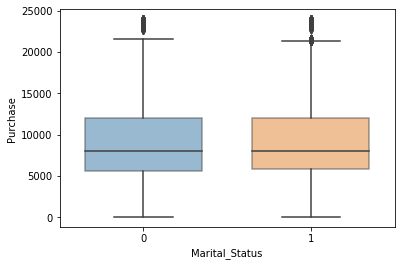

In [38]:
Purchase_by_Marital_Status=df.select('Purchase','Marital_Status').toPandas()
sns.boxplot(x=Purchase_by_Marital_Status['Marital_Status'],y=Purchase_by_Marital_Status['Purchase'],orient="v",width=0.7,boxprops=dict(alpha=.5)); 

In [39]:
df.select(fn.corr('Marital_Status', "Purchase")).show()

+------------------------------+
|corr(Marital_Status, Purchase)|
+------------------------------+
|          -4.63376419759242...|
+------------------------------+



### Product_Category_1

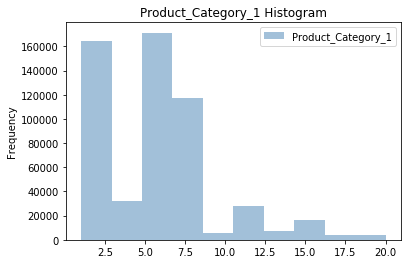

In [40]:
df.select('Product_Category_1').toPandas().plot(kind='hist', title='Product_Category_1 Histogram',alpha=0.5,color='steelblue');

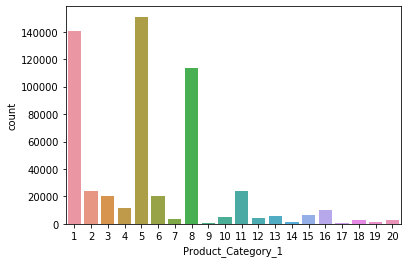

In [41]:
Product_Category_1_Count=df.groupBy('Product_Category_1').count().orderBy('count', ascending=False).toPandas()
sns.barplot(x='Product_Category_1', y='count',data=Product_Category_1_Count);

In [42]:
df.select('Product_Category_1').describe().show()

+-------+------------------+
|summary|Product_Category_1|
+-------+------------------+
|  count|            550068|
|   mean| 5.404270017525106|
| stddev| 3.936211369201384|
|    min|                 1|
|    max|                20|
+-------+------------------+



In [43]:
df.select(fn.corr('Product_Category_1', "Purchase")).show()

+----------------------------------+
|corr(Product_Category_1, Purchase)|
+----------------------------------+
|              -0.34370334591990886|
+----------------------------------+



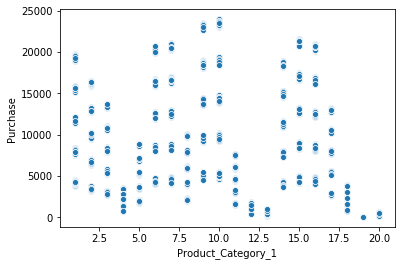

In [44]:
Product_by_Category_1=df.select('Purchase','Product_Category_1').toPandas()
sns.scatterplot(x='Product_Category_1',y='Purchase',data=Product_by_Category_1);

### Product_Category_2

In [45]:
df.select(fn.countDistinct('Product_Category_2')).show()

+----------------------------------+
|count(DISTINCT Product_Category_2)|
+----------------------------------+
|                                18|
+----------------------------------+



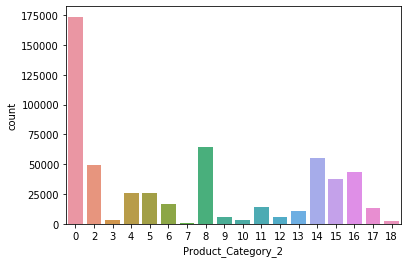

In [46]:
Product_Category_2_Count=df.groupBy('Product_Category_2').count().orderBy('count').toPandas()
sns.barplot(x='Product_Category_2', y='count',data=Product_Category_2_Count);
# df.groupBy('Product_Category_2').count().orderBy('count', ascending=False).show()

In [47]:
df.select('Product_Category_2').describe().show()

+-------+------------------+
|summary|Product_Category_2|
+-------+------------------+
|  count|            550068|
|   mean| 6.735436346051761|
| stddev| 6.215491528011076|
|    min|                 0|
|    max|                18|
+-------+------------------+



In [48]:
df.select(fn.corr('Product_Category_2', "Purchase")).show()

+----------------------------------+
|corr(Product_Category_2, Purchase)|
+----------------------------------+
|               0.05228771611534914|
+----------------------------------+



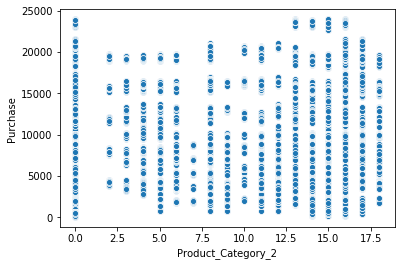

In [49]:
Product_by_Category_2=df.select('Purchase','Product_Category_2').toPandas()
sns.scatterplot(x='Product_Category_2',y='Purchase',data=Product_by_Category_2);

### Product_Category_3

In [50]:
df.select(fn.countDistinct('Product_Category_3')).show()

+----------------------------------+
|count(DISTINCT Product_Category_3)|
+----------------------------------+
|                                16|
+----------------------------------+



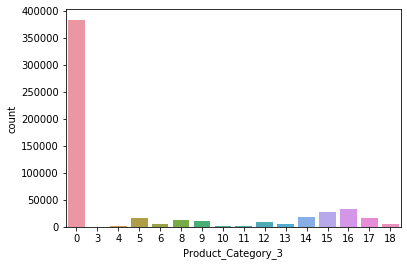

In [51]:
Product_Category_3_Count=df.groupBy('Product_Category_3').count().orderBy('count').toPandas()
sns.barplot(x='Product_Category_3', y='count',data=Product_Category_3_Count);
# df.groupBy('Product_Category_3').count().orderBy('count', ascending=False).show()

In [52]:
df.select('Product_Category_3').describe().show()

+-------+------------------+
|summary|Product_Category_3|
+-------+------------------+
|  count|            550068|
|   mean| 3.841941359977312|
| stddev| 6.250712413721696|
|    min|                 0|
|    max|                18|
+-------+------------------+



In [53]:
df.select(fn.corr('Product_Category_3', "Purchase")).show()

+----------------------------------+
|corr(Product_Category_3, Purchase)|
+----------------------------------+
|                0.2885005345490317|
+----------------------------------+



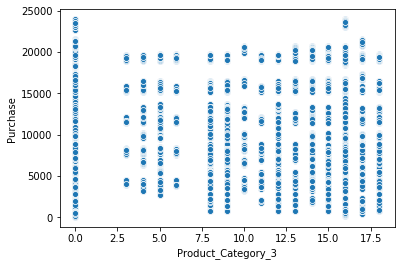

In [54]:
Product_by_Category_3=df.select('Purchase','Product_Category_3').toPandas()
sns.scatterplot(x='Product_Category_3',y='Purchase',data=Product_by_Category_3);

In [55]:
# colum=data.columns.tolist()
# fig=plt.figure(figsize=(20,20))

# for i in range(2,7):
#     plt.subplot(3,4,i-1)
#     sns.boxplot(x=data[colum[i]],y=data['Purchase'],orient="v",width=0.7,boxprops=dict(alpha=.5)) #,hue=data['label']
#     plt.ylabel(colum[i],fontsize=12)
    
# plt.tight_layout()
# fig.suptitle("Box Plot By Labels (all variables)", y=1.02,fontsize=16);

In [56]:
df.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = false)
 |-- Product_Category_3: integer (nullable = false)
 |-- Purchase: integer (nullable = true)



In [57]:
df=df.drop('User_ID','Product_ID')

In [58]:
df.describe().toPandas()

,summary,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,count,550068,550068,550068,550068,550068,550068,550068,550068,550068,550068
1,mean,None,None,8.076706879876669,None,1.468494139793958,0.40965298835780306,5.404270017525106,6.735436346051761,3.841941359977312,9263.968712959126
2,stddev,None,None,6.522660487341822,None,0.9890866807573164,0.49177012631733186,3.936211369201384,6.215491528011076,6.250712413721696,5023.065393820554
3,min,F,0-17,0,A,0,0,1,0,0,12
4,max,M,55+,20,C,4+,1,20,18,18,23961


In [59]:
from pyspark.sql.types import StringType
df = df.withColumn("Occupation",df["Occupation"].cast(StringType()))

Testing Preprocessing:<br/>
Fill NA --> Drop Id columns

In [60]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler

In [61]:
string_col=["Gender", "Age", "City_Category", "Stay_In_Current_City_Years","Marital_Status",'Occupation']

In [62]:
# indexer = StringIndexer(inputCol="string_col", outputCol="categoryIndex")

In [63]:
# encoder = OneHotEncoder(inputCols=["categoryIndex"], outputCols=["categoryVec"])

In [64]:
#Applyin string indexer to all the cateogrical columns
stringIndexer = StringIndexer(handleInvalid='skip', inputCols=[cols for cols in string_col],
                              outputCols=["encoded_" + cols for cols in string_col])
oneHotEncoder= feature.OneHotEncoder(inputCols=["encoded_" + cols for cols in string_col],
                                     outputCols=["onehot_" + cols for cols in string_col])
cat_vector = feature.VectorAssembler(inputCols=["onehot_" + cols for cols in string_col], 
                                     outputCol="cat_vec") # 

In [65]:
numeric_col = ['Product_Category_1', 'Product_Category_2', 'Product_Category_3']

In [66]:
numeric_vector = VectorAssembler(inputCols=[cols for cols in numeric_col], outputCol="num_vec")

In [67]:
standardScaler = StandardScaler(withMean=True, withStd=True, inputCol="num_vec", outputCol="scaled_num_vec")

In [68]:
all_vec = VectorAssembler(inputCols=['cat_vec','scaled_num_vec'], outputCol='final_features')

In [69]:
from pyspark.ml import Pipeline

In [70]:
preprocess_pipe=Pipeline(stages=[stringIndexer, oneHotEncoder, cat_vector, numeric_vector, standardScaler, all_vec ])

In [71]:
# Reduced variables in the model
preprocess_model = preprocess_pipe.fit(df)

In [72]:
preprocess_train = preprocess_model.transform(df)
preprocess_train.limit(5).toPandas()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,...,onehot_Gender,onehot_Marital_Status,onehot_Occupation,onehot_City_Category,onehot_Age,onehot_Stay_In_Current_City_Years,cat_vec,num_vec,scaled_num_vec,final_features
0,F,0-17,10,A,2,0,3,0,0,8370,...,(0.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 0.0, 0.0]","[-0.6108081584076389, -1.0836530491108325, -0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,F,0-17,10,A,2,0,1,6,14,15200,...,(0.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 6.0, 14.0]","[-1.118910953813613, -0.1183231193763836, 1.62...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,F,0-17,10,A,2,0,12,0,0,1422,...,(0.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.0, 0.0, 0.0]","[1.6756544209192448, -1.0836530491108325, -0.6...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,F,0-17,10,A,2,0,12,14,0,1057,...,(0.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.0, 14.0, 0.0]","[1.6756544209192448, 1.1687834536028816, -0.61...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,M,55+,16,C,4+,0,8,0,0,7969,...,(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[8.0, 0.0, 0.0]","[0.6594488301072965, -1.0836530491108325, -0.6...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."


In [73]:
preprocess_train.select('final_features').show(5)

+--------------------+
|      final_features|
+--------------------+
|(37,[10,13,26,34,...|
|(37,[10,13,26,34,...|
|(37,[10,13,26,34,...|
|(37,[10,13,26,34,...|
|(37,[0,6,8,12,13,...|
+--------------------+
only showing top 5 rows



Build the linear regression model

In [74]:
from pyspark.ml import regression, evaluation

In [75]:
lr=regression.LinearRegression(featuresCol='final_features', labelCol='Purchase')

In [76]:
lr_pipe=Pipeline(stages=[preprocess_pipe, lr])

In [77]:
lr_model=lr_pipe.fit(df)

In [78]:
print("coefficient of lr_model is:\n", lr_model.stages[1].coefficients)
print("Y intercept of lr_model is:\n",lr_model.stages[1].intercept)

coefficient of lr_model is:
 [430.8340738880246,177.75184300926693,276.90305948666486,-3.21962627761573,257.956808517246,589.4268205882662,426.9661948546291,141.1506495496825,629.918151914083,28.856765180975863,47.74554402915429,21.579511717090224,43.90589456566736,56.48003792455202,281.83491985058026,124.37271003031086,299.1828744979537,65.762623490034,435.8783699023172,24.195459615367582,545.3021575171933,427.11802786810614,141.32973640241775,295.2098498295638,318.37406639474017,334.6253730687888,-136.20049453225351,180.75448363133577,617.606177133422,180.65732685790314,-206.0711876349698,112.31876282509731,48.88588715934862,-133.9225096319981,-1368.0385128354383,75.5024435532425,894.5135988646554]
Y intercept of lr_model is:
 8181.535035021836


In [79]:
lr_model.stages[1].summary.meanSquaredError

21352009.76795343

In [80]:
lr_model.stages[1].summary.r2

0.15374375874095647

In [81]:
train_pre=lr_model.transform(df)

In [82]:
train_pre.columns

['Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Purchase',
 'encoded_Marital_Status',
 'encoded_Occupation',
 'encoded_City_Category',
 'encoded_Age',
 'encoded_Gender',
 'encoded_Stay_In_Current_City_Years',
 'onehot_Gender',
 'onehot_Marital_Status',
 'onehot_Occupation',
 'onehot_City_Category',
 'onehot_Age',
 'onehot_Stay_In_Current_City_Years',
 'cat_vec',
 'num_vec',
 'scaled_num_vec',
 'final_features',
 'prediction']

In [83]:
from pyspark.ml.evaluation import RegressionEvaluator

In [84]:
evaluator = RegressionEvaluator(
    labelCol='Purchase', predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(train_pre)
print("Root Mean Squared Error (RMSE) on training data = %g" % rmse)

Root Mean Squared Error (RMSE) on training data = 4620.82


In [85]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [86]:
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.01, 0.02, 0.2]) \
    .addGrid(lr.regParam, [0.01, 0.02, 0.05, 0.2]) \
    .build()
len(lr_paramGrid)

12

In [87]:
lr_cv=CrossValidator(estimator=lr_pipe,
                   estimatorParamMaps=lr_paramGrid, 
                   evaluator=evaluator,
                   numFolds=3)

In [88]:
lr_cv_model = lr_cv.fit(df)

In [89]:
lr_cv_model.bestModel.stages

[PipelineModel_d21affbf74c5,
 LinearRegressionModel: uid=LinearRegression_5f48a65b68ed, numFeatures=37]

In [94]:
lr_cv_model.bestModel.stages[1].coefficients

DenseVector([430.6271, 187.5149, 288.3691, 6.1944, 265.9658, 599.7997, 437.3256, 140.8046, 629.746, 27.338, 46.8669, 20.9058, 43.0174, 56.5928, 106.3352, -49.3633, 124.0312, -108.118, 262.0104, -150.9642, 372.1937, 251.3313, -32.001, 121.3882, 144.6554, 159.4176, -300.8407, 5.5157, 444.3548, 5.4398, -379.1848, -59.4813, -126.3781, -307.8995, -1367.9394, 75.508, 894.4989])

In [91]:
lr_cv_model.bestModel.stages[1].getElasticNetParam()

0.2

In [92]:
lr_cv_model.bestModel.stages[1].getRegParam()

0.02

In [100]:
lr_cv_model.bestModel.stages[1].summary.degreesOfFreedom

550030

In [101]:
lr_cv_model.bestModel.stages[1].summary.meanSquaredError

21352097.125844993

In [102]:
test_df = spark.read.csv(get_training_filename('test.csv'), header=True, inferSchema=True)

In [103]:
test_df.show(5)

+-------+----------+------+-----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+
|User_ID|Product_ID|Gender|  Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|
+-------+----------+------+-----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+
|1000004| P00128942|     M|46-50|         7|            B|                         2|             1|                 1|                11|              null|
|1000009| P00113442|     M|26-35|        17|            C|                         0|             0|                 3|                 5|              null|
|1000010| P00288442|     F|36-45|         1|            B|                        4+|             1|                 5|                14|              null|
|1000010| P00145342|     F|36-45|         1|        

In [104]:
shape=(test_df.count(),len(test_df.columns))
print(shape)

(233599, 11)


In [105]:
print(test_df.printSchema())

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)

None


In [106]:
test_df.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in test_df.columns]).show()

+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+
|User_ID|Product_ID|Gender|Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+
|      0|         0|     0|  0|         0|            0|                         0|             0|                 0|             72344|            162562|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+



In [107]:
testing=test_df.na.fill({'Product_Category_2':0, 'Product_Category_3':0})

In [108]:
testing.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in testing.columns]).show()

+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+
|User_ID|Product_ID|Gender|Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+
|      0|         0|     0|  0|         0|            0|                         0|             0|                 0|                 0|                 0|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+



In [109]:
testing=testing.drop('User_ID','Product_ID')

In [110]:
testing = testing.withColumn("Occupation",testing["Occupation"].cast(StringType()))

In [111]:
preprocess_test=preprocess_model.transform(testing)

In [112]:
preprocess_test.limit(5).toPandas()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,encoded_Marital_Status,...,onehot_Gender,onehot_Marital_Status,onehot_Occupation,onehot_City_Category,onehot_Age,onehot_Stay_In_Current_City_Years,cat_vec,num_vec,scaled_num_vec,final_features
0,M,46-50,7,B,2,1,1,11,0,1.0,...,(1.0),(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 11.0, 0.0]","[-1.118910953813613, 0.6861184887356572, -0.61...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
1,M,26-35,17,C,0,0,3,5,0,0.0,...,(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0)","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[3.0, 5.0, 0.0]","[-0.6108081584076389, -0.27921144099879175, -0...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,F,36-45,1,B,4+,1,5,14,0,1.0,...,(0.0),(0.0),"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[5.0, 14.0, 0.0]","[-0.10270536300166475, 1.1687834536028816, -0....","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,F,36-45,1,B,4+,1,4,9,0,1.0,...,(0.0),(0.0),"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[4.0, 9.0, 0.0]","[-0.35675676070465184, 0.36434184549084087, -0...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,F,26-35,1,C,1,0,4,5,12,0.0,...,(0.0),(1.0),"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[4.0, 5.0, 12.0]","[-0.35675676070465184, -0.27921144099879175, 1...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [113]:
preprocess_test.select('final_features').show(5)

+--------------------+
|      final_features|
+--------------------+
|(37,[0,4,7,10,16,...|
|(37,[0,1,8,13,18,...|
|(37,[2,7,12,17,34...|
|(37,[2,7,12,17,34...|
|(37,[1,8,9,13,17,...|
+--------------------+
only showing top 5 rows



In [114]:
test_pre=lr_model.transform(testing)

In [115]:
train_pre.columns

['Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Purchase',
 'encoded_Marital_Status',
 'encoded_Occupation',
 'encoded_City_Category',
 'encoded_Age',
 'encoded_Gender',
 'encoded_Stay_In_Current_City_Years',
 'onehot_Gender',
 'onehot_Marital_Status',
 'onehot_Occupation',
 'onehot_City_Category',
 'onehot_Age',
 'onehot_Stay_In_Current_City_Years',
 'cat_vec',
 'num_vec',
 'scaled_num_vec',
 'final_features',
 'prediction']

In [146]:
comb=test_df.select(test_df.columns[:2])

In [147]:
comb.take(5)

[Row(User_ID=1000004, Product_ID='P00128942'),
 Row(User_ID=1000009, Product_ID='P00113442'),
 Row(User_ID=1000010, Product_ID='P00288442'),
 Row(User_ID=1000010, Product_ID='P00145342'),
 Row(User_ID=1000011, Product_ID='P00053842')]

In [132]:
#comb=comb.select(fn.concat(fn.col("User_ID"), fn.lit(""), fn.col("Product_ID")))

In [133]:
#comb.take(5)

[Row(concat(User_ID, , Product_ID)='1000004P00128942'),
 Row(concat(User_ID, , Product_ID)='1000009P00113442'),
 Row(concat(User_ID, , Product_ID)='1000010P00288442'),
 Row(concat(User_ID, , Product_ID)='1000010P00145342'),
 Row(concat(User_ID, , Product_ID)='1000011P00053842')]

In [148]:
comb=comb.toPandas()

In [149]:
comb

,User_ID,Product_ID
0,1000004,P00128942
1,1000009,P00113442
2,1000010,P00288442
3,1000010,P00145342
4,1000011,P00053842
...,...,...
233594,1006036,P00118942
233595,1006036,P00254642
233596,1006036,P00031842
233597,1006037,P00124742


In [150]:
prediction=test_pre.select('prediction').toPandas()

In [151]:
prediction

,prediction
0,10391.117549
1,10177.121114
2,8388.203824
3,8675.018613
4,10774.746327
...,...
233594,7628.175413
233595,8768.011393
233596,11839.047758
233597,7201.039555


In [152]:
result = pd.concat([comb, prediction], axis=1)

In [153]:
result

,User_ID,Product_ID,prediction
0,1000004,P00128942,10391.117549
1,1000009,P00113442,10177.121114
2,1000010,P00288442,8388.203824
3,1000010,P00145342,8675.018613
4,1000011,P00053842,10774.746327
...,...,...,...
233594,1006036,P00118942,7628.175413
233595,1006036,P00254642,8768.011393
233596,1006036,P00031842,11839.047758
233597,1006037,P00124742,7201.039555


In [154]:
result.columns = ['User_ID','Product_ID','Purchase']

In [155]:
result.to_csv('submission.csv', index = False, header=True)